In [ ]:
import torch
torch.__version__

'1.3.0'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import os
from pathlib import Path

DATASET_FOLDER = Path("/kaggle/input/deepfake-detection-challenge")

data_folder_contents = os.listdir(DATASET_FOLDER)
print("Contents of 'data' folder:", data_folder_contents)

Contents of 'data' folder: ['test_videos', 'sample_submission.csv', 'train_sample_videos']


In [ ]:
TRAIN_VIDEOS = DATASET_FOLDER / "train_sample_videos"
TRAIN_METADATA_PATH = TRAIN_VIDEOS / "metadata.json"
TEST_VIDEOS = DATASET_FOLDER / "test_videos"

In [ ]:
import json

def load_metadata(metadata_path: str):
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return metadata

def load_video_data_from_json(metadata: str):
    video_paths = []
    labels = []

    for video, info in metadata.items():
        video_paths.append(video)
        labels.append(1 if info['label'] == 'FAKE' else 0) #1 for FAKE, 0 for REAL

    return video_paths, labels

In [ ]:
train_metadata = load_metadata(TRAIN_METADATA_PATH)
train_video_paths, train_labels = load_video_data_from_json(train_metadata)

len(train_video_paths), len(train_labels)

(400, 400)

In [ ]:
fake = 0
for label in train_labels:
    if label == 1:
        fake = fake + 1

fake, (len(train_labels)-fake)

(323, 77)

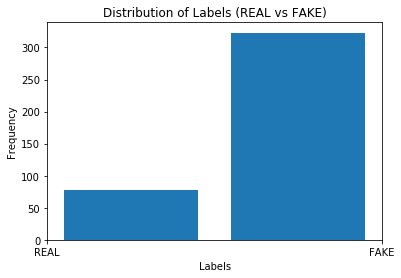

In [ ]:
import matplotlib.pyplot as plt

def visualize_data_distribution(labels):
    plt.figure(figsize=(6, 4))
    plt.hist(labels, bins=2, rwidth=0.8)
    plt.xticks([0, 1], ["REAL", "FAKE"])
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Distribution of Labels (REAL vs FAKE)')
    plt.show()

visualize_data_distribution(train_labels)

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2

def show_random_frames(video_paths, video_dir, num_videos=3):
    for _ in range(num_videos):
        video_path = os.path.join(video_dir, random.choice(video_paths))
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames > 0:
            random_frame_index = random.randint(0, total_frames - 1)
            cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)
            ret, frame = cap.read()

            if ret:
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"Video: {os.path.basename(video_path)} (Frame {random_frame_index})")
                plt.axis('off')
                plt.show()

        cap.release()

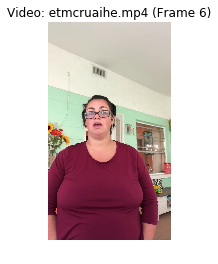

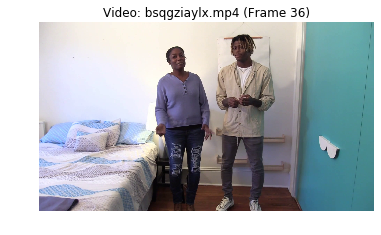

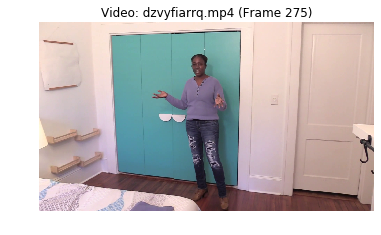

In [ ]:
show_random_frames(train_video_paths, TRAIN_VIDEOS, num_videos=3)

In [ ]:
import cv2
from torchvision import transforms

IMG_SIZE = 224
MAX_NUM_FRAMES = 40

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_video(path, max_frames=MAX_NUM_FRAMES, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_tensor = transform(frame)
        frames.append(frame_tensor)
        if len(frames) == max_frames:
            break

    cap.release()

    #padding with zeros if frames are less than 20
    if len(frames) < max_frames:
        pad_frames = [torch.zeros_like(frames[0])] * (max_frames - len(frames))
        frames.extend(pad_frames)

    return torch.stack(frames)

In [ ]:
sample_video_path = os.path.join(TRAIN_VIDEOS, train_video_paths[0])
video_tensor = load_video(sample_video_path)

#video tensor: (num_frames, color_channels, IMG_Height, IMG_Width)
print(f"Video tensor shape: {video_tensor.shape}")

Video tensor shape: torch.Size([40, 3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

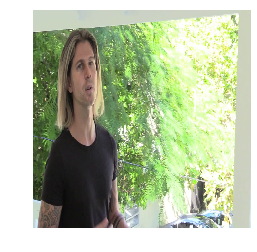

In [ ]:
import matplotlib.pyplot as plt

img = video_tensor[0]
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.axis('off')

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.8MB/s eta 0:00:01


In [ ]:
import cv2
import numpy as np
from mtcnn import MTCNN

IMG_SIZE = 224
#Suggested number of frames is 100 per video
MAX_NUM_FRAMES = 20

detector = MTCNN()

def extract_faces_from_video(video_path, max_faces=MAX_NUM_FRAMES, target_size=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(video_path)
    faces = []
    face_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detected_faces = detector.detect_faces(frame_rgb)

        for face in detected_faces:
            x, y, width, height = face['box']
            face_img = frame_rgb[y:y+height, x:x+width]
            face_img = cv2.resize(face_img, target_size)
            face_array = face_img.astype('float32') / 255.0
            faces.append(face_array)

            face_count += 1
            if face_count >= max_faces:
                cap.release()
                return np.array(faces)

    cap.release()

    return np.array(faces)

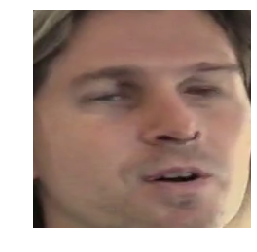

In [ ]:
import matplotlib.pyplot as plt

sample_video_path = os.path.join(TRAIN_VIDEOS, train_video_paths[0])
faces = extract_faces_from_video(sample_video_path, target_size=(224, 224), max_faces=20)

face_img = faces[5]
plt.imshow(face_img)
plt.axis('off')
plt.show()

In [ ]:
import torch
from torchvision import transforms
import numpy as np

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def faces_to_tensor(faces_array):
    tensors = []

    for face in faces_array:
        #Convert float32 array back to uint8
        face_uint8 = (face * 255).astype(np.uint8)
        face_tensor = transform(face_uint8)
        tensors.append(face_tensor)

    return torch.stack(tensors)

faces_tensor = faces_to_tensor(faces)
print(f"Faces tensor shape: {faces_tensor.shape}")

Faces tensor shape: torch.Size([20, 3, 224, 224])


In [ ]:
face = faces_tensor[0]
face.shape

torch.Size([3, 224, 224])

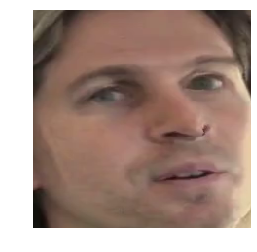

In [ ]:
face = face.permute(1, 2, 0)
plt.imshow(face)
plt.axis('off')
plt.show()

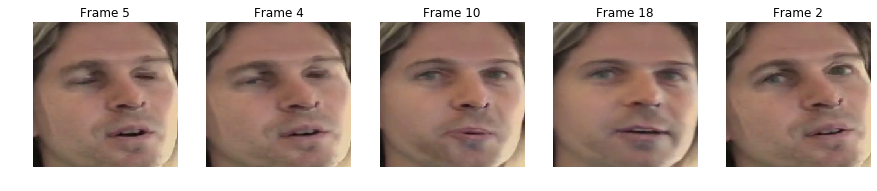

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def show_random_frames(frames_tensor, num_frames=5):
    total_frames = frames_tensor.shape[0]

    random_indices = random.sample(range(total_frames), num_frames)

    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        frame = frames_tensor[idx]

        #frame = unnormalize(frame)

        frame_np = frame.permute(1, 2, 0).numpy()
        frame_np = np.clip(frame_np, 0, 1)

        axes[i].imshow(frame_np)
        axes[i].axis('off')
        axes[i].set_title(f"Frame {idx + 1}")

    plt.show()

show_random_frames(faces_tensor, num_frames=5)

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    train_video_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print(f"Training samples: {len(train_paths)}, Testing samples: {len(test_paths)}")

Training samples: 320, Testing samples: 80


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, video_dir):
        self.video_paths = video_paths
        self.labels = labels
        self.video_dir = video_dir

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.video_paths[idx])
        label = self.labels[idx]
        video_tensor = load_video(video_path)
        #Uncomment the below commented line, and comment the just above line[a/c to research paper]
        #faces = extract_faces_from_video(video_path)
        #video_tensor = faces_to_tensor(faces_array)
        return video_tensor, label

In [ ]:
train_dataset = VideoDataset(train_paths,
                             train_labels,
                             TRAIN_VIDEOS)

test_dataset = VideoDataset(test_paths,
                            test_labels,
                            TRAIN_VIDEOS)

len(train_dataset), len(test_dataset)

(320, 80)

In [ ]:
import os

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

Creating DataLoader's with batch size 16 and 4 workers.


(20, 5)

In [ ]:
video, label = next(iter(train_dataloader))
video.shape, label

(torch.Size([16, 40, 3, 224, 224]),
 tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]))

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.models as models

class DeepFakeDetectorSimple(nn.Module):
    def __init__(self, hidden_size=256, num_layers=1):
        super().__init__()

        resnet = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(
            *list(resnet.children())[:-2]
        )

        self.cnn_fc = nn.Linear(512 * 7 * 7,
                                hidden_size)

        self.lstm = nn.LSTM(input_size=hidden_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, video_tensor):
        batch_size, seq_len, c, h, w = video_tensor.shape
        video_features = []

        for t in range(seq_len):
            frame = video_tensor[:, t]
            cnn_out = self.cnn(frame).view(batch_size, -1)
            video_features.append(self.cnn_fc(cnn_out))

        video_features = torch.stack(video_features, dim=1)
        lstm_out, _ = self.lstm(video_features)
        final_output = lstm_out[:, -1, :]
        out = self.fc(final_output)
        return out

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.models as models

#Model suggested in research paper
class DeepFakeDetector(nn.Module):
    def __init__(self, hidden_size=2048, num_layers=1, dropout=0.4):
        super().__init__()

        resnext = models.resnext50_32x4d(pretrained=True)

        self.cnn = nn.Sequential(
            *list(resnext.children())[:-2] #remove fully connected layer
        )

        self.cnn_fc = nn.Linear(2048*7*7,
                                hidden_size)

        self.lstm = nn.LSTM(input_size=hidden_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, video_tensor):
        batch_size, seq_len, c, h, w = video_tensor.shape
        video_features = []

        for t in range(seq_len):
            frame = video_tensor[:, t]
            cnn_out = self.cnn(frame).view(batch_size, -1)
            video_features.append(self.cnn_fc(cnn_out))

        video_features = torch.stack(video_features, dim=1)

        lstm_out, _ = self.lstm(video_features)

        lstm_out = self.dropout(lstm_out)

        final_output = lstm_out[:, -1, :]

        out = self.fc(final_output)

        return out

In [ ]:
model_0 = DeepFakeDetectorSimple(hidden_size=256, num_layers=1)
#model suggested in research paper, uncomment this, comment the above one.
#model_1 = DeepFakeDetector(hidden_size=2048,
                          # num_layers=1,
                         #  dropout=0.4)
model_0.to(device)
model_0

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 251MB/s]


DeepFakeDetectorSimple(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
video_batch, label_batch = next(iter(train_dataloader))

print(f"Video batch shape -> [batch_size, num_frames, 3, height, width]: {video_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

Video batch shape -> [batch_size, num_frames, 3, height, width]: torch.Size([16, 40, 3, 224, 224])
Label batch shape: torch.Size([16])


In [ ]:
#Model needs Input like this: [batch_size, num_frames, 3, height, width]
#choose single video(sequence of frames) and unsqueeze(add batch dimension)

video_single, label_single = video_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single video shape (with batch dim): {video_single.shape}")
print(f"Single label: {label_single}")

Single video shape (with batch dim): torch.Size([1, 40, 3, 224, 224])
Single label: 1


In [ ]:
model_0.eval()

with torch.no_grad():
    pred = model_0(video_single.to(device))

#raw logits -> pred_prob
pred_prob = torch.sigmoid(pred)

#pred_prob -> pred_label (0 or 1)
pred_label = (pred_prob > 0.5).float()

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{pred_prob}\n")
print(f"Output prediction label (FAKE=1, REAL=0):\n{pred_label.item()}\n")
print(f"Actual label (FAKE=1, REAL=0):\n{label_single.item()}")

Output logits:
tensor([[0.0607]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5152]], device='cuda:0')

Output prediction label (FAKE=1, REAL=0):
1.0

Actual label (FAKE=1, REAL=0):
1


In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, num_frames, 3, height, width]
summary(model_0, input_size=[1, 40, 3, 224, 224])

Layer (type:depth-idx)                        Output Shape              Param #
DeepFakeDetectorSimple                        --                        --
├─Sequential: 1-1                             [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]          295,42

In [ ]:
from tqdm.auto import tqdm
import torch

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device,
               epochs=5):

    model = model.to(device)
    model.train()

    cur_loss = 0.0
    correct = 0
    total = 0

    for video_tensors, labels in dataloader:
        video_tensors, labels = video_tensors.to(device), labels.to(device)

        outputs = model(video_tensors).squeeze()
        loss = loss_fn(outputs, labels.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cur_loss += loss.item() * video_tensors.size(0)

        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = cur_loss / len(dataloader.dataset)
    train_acc = correct / total

    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):

    model = model.to(device)
    model.eval()
    cur_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for video_tensors, labels in dataloader:
            video_tensors, labels = video_tensors.to(device), labels.to(device)
            outputs = model(video_tensors).squeeze()
            loss = loss_fn(outputs, labels.float())
            cur_loss += loss.item() * video_tensors.size(0)

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = cur_loss / len(dataloader.dataset)
    accuracy = correct / total

    return test_loss, accuracy

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device = device,
          epochs: int = 5):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           epochs=epochs)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = DeepFakeDetectorSimple(hidden_size=256,
                           num_layers=1)

#model_1 = DeepFakeDetector(hidden_size=2048,
                           #num_layers=1,
                           #dropout=0.4)
model_0.to(device)

loss_fn = nn.BCEWithLogitsLoss()
#Use learning rate(lr) of 1e-5 and decay of 1e−6, suggested by research paper
optimizer = optim.Adam(model_0.parameters(),
                       lr=1e-5,
                       weight_decay=1e-6)

In [ ]:
NUM_EPOCHS = 20

from timeit import default_timer as timer

start = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device,
                        epochs=NUM_EPOCHS)

model_0_results

end = timer()

print(f"Time taken to train model_0: {end-start: .3f} seconds")

Epoch: 1 | train_loss: 0.5138 | train_acc: 0.7438 | test_loss: 0.4785 | test_acc: 0.8125
Epoch: 2 | train_loss: 0.4508 | train_acc: 0.8094 | test_loss: 0.4771 | test_acc: 0.8000
Epoch: 3 | train_loss: 0.4128 | train_acc: 0.8281 | test_loss: 0.4919 | test_acc: 0.8125
Epoch: 4 | train_loss: 0.3893 | train_acc: 0.8250 | test_loss: 0.5007 | test_acc: 0.8125
Epoch: 5 | train_loss: 0.3753 | train_acc: 0.8219 | test_loss: 0.5237 | test_acc: 0.7750
Epoch: 6 | train_loss: 0.3658 | train_acc: 0.8500 | test_loss: 0.5480 | test_acc: 0.7875
Epoch: 7 | train_loss: 0.3436 | train_acc: 0.8438 | test_loss: 0.5315 | test_acc: 0.8000
Epoch: 8 | train_loss: 0.3180 | train_acc: 0.8594 | test_loss: 0.5744 | test_acc: 0.7500
Epoch: 9 | train_loss: 0.2952 | train_acc: 0.8781 | test_loss: 0.5794 | test_acc: 0.7750
Epoch: 10 | train_loss: 0.2730 | train_acc: 0.8688 | test_loss: 0.5748 | test_acc: 0.7250
Epoch: 11 | train_loss: 0.2538 | train_acc: 0.9031 | test_loss: 0.6304 | test_acc: 0.7625
Epoch: 12 | train_l

In [ ]:
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

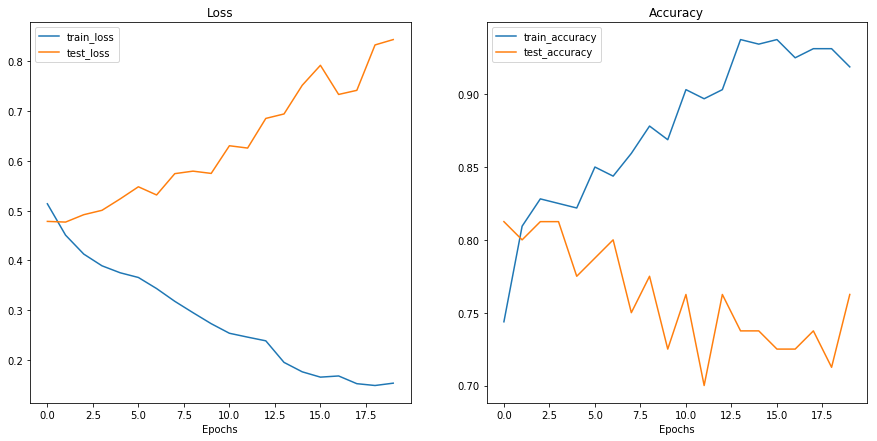

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "deepfake_detection_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/deepfake_detection_model.pth


In [ ]:
#loaded_model = DeepFakeDetector(hidden_size=2048,
                                #num_layers=1,
                                #dropout=0.4)
loaded_model = DeepFakeDetectorSimple(hidden_size=256, num_layers=1)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model = loaded_model.to(device)

In [ ]:
def predict_deepfake_video(video_path, model, device):

    video_frames = load_video(video_path)

    video_input = video_frames.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred_logits = model(video_input)

    pred_prob = torch.sigmoid(pred_logits)

    #Convert probabilities to prediction label(0 for Real, 1 for Deepfake)
    pred_label = (pred_prob > 0.5).float()

    if pred_label.item() == 1.0:
        result_message = f"Deepfake Detected with probability: {pred_prob.item():.4f}"
    else:
        result_message = f"Real Video Detected with probability: {pred_prob.item():.4f}"

    return result_message

In [ ]:
video_file_path = "/kaggle/input/deepfake-detection-challenge/test_videos/btdxnajogv.mp4"  #video path
result = predict_deepfake_video(video_file_path, loaded_model, device)
print(result)

Deepfake Detected with probability: 0.8308


In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML
import os
import torch

# Create file upload and result display widgets
upload_widget = widgets.FileUpload(accept='.mp4', multiple=False)
result_label = widgets.HTML(value="<b>Upload a video to see the result!</b>", layout=widgets.Layout(margin='10px 0px'))
progress_bar = widgets.FloatProgress(value=0.0, min=0.0, max=1.0, step=0.01, description='Processing:', bar_style='info')

# Display the widgets
display(upload_widget)
display(progress_bar)
display(result_label)

def save_uploaded_file(uploaded_file, save_dir='uploaded_videos'):
    """Saves the uploaded file to a specified directory."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename, file_info in uploaded_file.value.items():
        file_path = os.path.join(save_dir, filename)
        with open(file_path, 'wb') as f:
            f.write(file_info['content'])
        print(f"File saved to {file_path}")

    return file_path

def show_result_message(result, score):
    """Displays a styled result based on the prediction."""
    if "Deepfake" in result:
        result_html = f"""
        <div style="font-size:18px; color: white; background-color: red; padding: 10px; border-radius: 5px;">
            <b>{result}</b> (Confidence: {score:.4f})
        </div>
        """
    else:
        result_html = f"""
        <div style="font-size:18px; color: white; background-color: green; padding: 10px; border-radius: 5px;">
            <b>{result}</b> (Confidence: {score:.4f})
        </div>
        """
    return result_html

def on_upload_change(change):

    if upload_widget.value:
        progress_bar.value = 0.3
        video_file_path = save_uploaded_file(upload_widget)

        progress_bar.value = 0.6
        result = predict_deepfake_video(video_file_path, loaded_model, device)

        result_message = result.split(" with probability: ")[0]
        score = float(result.split(" with probability: ")[1])

        progress_bar.value = 1.0
        progress_bar.bar_style = 'success'

        result_label.value = show_result_message(result_message, score)

upload_widget.observe(on_upload_change, names='value')

FileUpload(value={}, accept='.mp4', description='Upload')

FloatProgress(value=0.0, bar_style='info', description='Processing:', max=1.0)

HTML(value='<b>Upload a video to see the result!</b>', layout=Layout(margin='10px 0px'))